# Exploring precision and recall
The goal of this assignment is to understand precision-recall in the context of classifiers.

1. Use Amazon review data in its entirety.
2. Train a logistic regression model.
3. Explore various evaluation metrics: accuracy, confusion matrix, precision, recall.
4. Explore how various metrics can be combined to produce a cost of making an error.
5. Explore precision and recall curves.

## Load Amazon dataset

Load the dataset consisting of baby product reviews on Amazon.com. Store the data in a data frame products. In SFrame, you would run

In [11]:
import numpy as np
import pandas as pd
from sklearn import linear_model 

products = pd.read_csv('/Users/kevinwang/Documents/Coursera/Machine Learning - Classification/Week6/amazon_baby.csv')  

## Perform text cleaning

We start by removing punctuation, so that words "cake." and "cake!" are counted as the same word.

Write a function remove_punctuation that strips punctuation from a line of text
Apply this function to every element in the review column of products, and save the result to a new column review_clean.
Refer to your tool's manual for string processing capabilities. Python lets us express the operation in a succinct way, as follows:

In [12]:
products = products.fillna({'review':''})  # fill empty string to replace N/A's in 'review' column

def remove_punctuation(text):
    import string
    return text.translate(str.maketrans('','',string.punctuation))    # nature's will change to natures

products['review_clean'] = products['review'].apply(remove_punctuation)

Aside. In this notebook, we remove all punctuation for the sake of simplicity. A smarter approach to punctuation would preserve phrases such as "I'd", "would've", "hadn't" and so forth. See this page for an example of smart handling of punctuation.

## Extract Sentiments

We will ignore all reviews with rating = 3, since they tend to have a neutral sentiment. In SFrame, for instance,

In [13]:
products = products[products['rating'] != 3]

Now, we will assign reviews with a rating of 4 or higher to be positive reviews, while the ones with rating of 2 or lower are negative. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label. A good way is to create an anonymous function that converts a rating into a class label and then apply that function to every element in the rating column. In SFrame, you would use apply():

In [14]:
products['sentiment'] = products['rating'].apply(lambda x : +1 if x >= 4 else -1)

In [174]:
products[['sentiment','rating']].head()

,sentiment,rating
1,1,5
2,1,5
3,1,5
4,1,5
5,1,5


Now, we can see that the dataset contains an extra column called sentiment which is either positive (+1) or negative (-1).



## Split into training and test sets

Let's perform a train/test split with 80% of the data in the training set and 20% of the data in the test set. If you are using SFrame, make sure to use seed=1 so that you get the same result as everyone else does. (This way, you will get the right numbers for the quiz.) If you are other tools, consult appropriate manuals to perform a train/test split.

In [16]:
import json
with open('/Users/kevinwang/Documents/Coursera/Machine Learning - Classification/Week6/module-9-assignment-train-idx.json', 'r') as f: # Reads the list of most frequent words
    train_idx = json.load(f)
with open('/Users/kevinwang/Documents/Coursera/Machine Learning - Classification/Week6/module-9-assignment-test-idx.json', 'r') as f1: # Reads the list of most frequent words
    validation_idx = json.load(f1)

In [175]:
train_data = products.iloc[train_idx]
test_data = products.iloc[validation_idx]
print(train_data.shape)

(133416, 5)


## Build the word count vector for each review

We will now compute the word count for each word that appears in the reviews. A vector consisting of word counts is often referred to as bag-of-word features. Since most words occur in only a few reviews, word count vectors are sparse. For this reason, scikit-learn and many other tools use sparse matrices to store a collection of word count vectors. Refer to appropriate manuals to produce sparse word count vectors. General steps for extracting word count vectors are as follows:

Learn a vocabulary (set of all words) from the training data. Only the words that show up in the training data will be considered for feature extraction.
Compute the occurrences of the words in each review and collect them into a row vector.
Build a sparse matrix where each row is the word count vector for the corresponding review. Call this matrix train_matrix.
Using the same mapping between words and columns, convert the test data into a sparse matrix test_matrix.
The following cell uses CountVectorizer in scikit-learn. Notice the token_pattern argument in the constructor.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
# Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])
print(train_matrix.shape)

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

(133416, 121712)


## Train a sentiment classifier with logistic regression

Learn a logistic regression classifier using the training data. If you are using scikit-learn, you should create an instance of the LogisticRegression class and then call the method fit() to train the classifier. This model should use the sparse word count matrix (train_matrix)as features and the column sentiment of train_data as the target. Use the default values for other parameters. Call this model model.



In [20]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
sentiment_model = model.fit(train_matrix, train_data['sentiment'])
print(sentiment_model.coef_)
print(type(sentiment_model.coef_))   #nd_array
print(len(sentiment_model.coef_[0]))
print(len(sentiment_model.coef_[sentiment_model.coef_>=0]))

[[-1.23601561e+00  2.10974685e-04  2.58193001e-02 ...  1.13607892e-02
   3.21530781e-03 -7.24674495e-05]]
<class 'numpy.ndarray'>
121712
85778


In [22]:
sample_test_data = test_data[10:13]       #rating 5 is the best, sentiment 1 is the best, -1 not good
print(sample_test_data)
print()
print('Positive review is: ' + str(sample_test_data.iloc[0]['review']))
print()
print('Negative review is: ' + str(sample_test_data.iloc[1]['review']))

                                                 name  \
59                          Our Baby Girl Memory Book   
71  Wall Decor Removable Decal Sticker - Colorful ...   
91  New Style Trailing Cherry Blossom Tree Decal R...   

                                               review  rating  \
59  Absolutely love it and all of the Scripture in...       5   
71  Would not purchase again or recommend. The dec...       2   
91  Was so excited to get this product for my baby...       1   

                                         review_clean  sentiment  
59  Absolutely love it and all of the Scripture in...          1  
71  Would not purchase again or recommend The deca...         -1  
91  Was so excited to get this product for my baby...         -1  

Positive review is: Absolutely love it and all of the Scripture in it.  I purchased the Baby Boy version for my grandson when he was born and my daughter-in-law was thrilled to receive the same book again.

Negative review is: Would not purc

In [23]:
#sample_test_matrix = vectorizer.transform(sample_test_data['review_clean'])
sample_test_matrix = test_matrix[10:13]
scores = sentiment_model.decision_function(sample_test_matrix)    #beta*X
prob = sentiment_model.predict_proba(sample_test_matrix)   #3.68*e-03 is the probabilty of -1, 9.6e-01 is prob of 1 
decisions = sentiment_model.predict(sample_test_matrix)     #Predicted results are 1, -1, -1
print(scores)   #beta*X
print(prob)    #sigmoid transform of beta*X, that's the probability.   Probility of two number sum up to 1.
print(decisions)   #decision based on probability   

[  5.59918235  -3.14112546 -10.4101683 ]
[[3.68724245e-03 9.96312758e-01]
 [9.58557613e-01 4.14423872e-02]
 [9.99969876e-01 3.01236967e-05]]
[ 1 -1 -1]


## Model Evaluation

We will explore the advanced model evaluation concepts that were discussed in the lectures.

## Accuracy

One performance metric we will use for our more advanced exploration is accuracy, which we have seen many times in past assignments. Recall that the accuracy is given by

accuracy = # correctly classified data points / # total data points
Compute the accuracy on the test set using your tool of choice. If you are using scikit-learn, you can use the pre-defined method accuracy_score:

In [24]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'].to_numpy(), y_pred=model.predict(test_matrix))
print("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.9322954163666907


In [25]:
decisions_test = sentiment_model.predict(test_matrix)       #Predicted results ex: 1, -1, -1,....
decisions_train = sentiment_model.predict(train_matrix)     #Predicted results ex: 1, -1, -1,....
accuracy_test = sum(test_data['sentiment'] == decisions_test)/len(test_data)
accuracy_train = sum(train_data['sentiment'] == decisions_train)/len(train_data)
print('Training data accuracy = ' + str(accuracy_train))
print('Test data accuracy = ' + str(accuracy_test))

Training data accuracy = 0.967687533729088
Test data accuracy = 0.9322954163666907


## Baseline: Majority class prediction

Recall from an earlier assignment that we used the majority class classifier as a baseline (i.e reference) model for a point of comparison with a more sophisticated classifier. The majority classifier model predicts the majority class for all data points.

Typically, a good model should beat the majority class classifier. Since the majority class in this dataset is the positive class (i.e., there are more positive than negative reviews), the accuracy of the majority class classifier is simply the fraction of positive reviews in the test set:

In [27]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


Quiz question: Using accuracy as the evaluation metric, was our logistic regression model better than the baseline (majority class classifier)?

Answer: Yes

## Confusion Matrix

The accuracy, while convenient, does not tell the whole story. For a fuller picture, we turn to the confusion matrix. In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:

Using your tool, print out the confusion matrix for a classifier. For instance, scikit-learn provides the method confusion_matrix for this purpose:

In [29]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print(' target_label | predicted_label | count ')
print('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3788
     -1       |        1        |  1453
      1       |       -1        |   804
      1       |        1        | 27291


Quiz Question: How many predicted values in the test set are false positives?

Answer: 1453

## Computing the cost of mistakes

Put yourself in the shoes of a manufacturer that sells a baby product on Amazon.com and you want to monitor your product's reviews in order to respond to complaints. Even a few negative reviews may generate a lot of bad publicity about the product. So you don't want to miss any reviews with negative sentiments --- you'd rather put up with false alarms about potentially negative reviews instead of missing negative reviews entirely. In other words, false positives cost more than false negatives. (It may be the other way around for other scenarios, but let's stick with the manufacturer's scenario for now.)

Suppose you know the costs involved in each kind of mistake:

100 dollar for each false positive.  (positve = 1, 1 means good review) 
1 dollar for each false negative.    (positve = 0, 1 means bad review) 
Correctly classified reviews incur no cost.

Quiz Question: Given the stipulation, what is the cost associated with the logistic regression classifier's performance on the test set?

Answer: 146104

In [31]:
test_cost = sum(test_data['sentiment'] < decisions_test)*100 + sum(test_data['sentiment'] > decisions_test)
print(test_cost)

146104


## Precision and Recall


You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where precision comes in:

[precision]= [# positive data points with positive predictions] / [# all data points with positive predictions] = [# true positives] / ([# true positives]+[# false positives])

So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher.

First, let us compute the precision of the logistic regression classifier on the test_data. Scikit-learn provides a predefined method for computing precision. (Consult appropriate manuals if you are using other tools.)

In [32]:
from sklearn.metrics import classification_report
print(classification_report(test_data['sentiment'], decisions_test))

             precision    recall  f1-score   support

         -1       0.82      0.72      0.77      5241
          1       0.95      0.97      0.96     28095

avg / total       0.93      0.93      0.93     33336



In [35]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=model.predict(test_matrix))
print("Precision on test data: %s" % precision)

Precision on test data: 0.9494503200667965


Quiz Question: Out of all reviews in the test set that are predicted to be positive, what fraction of them are false positives? (Round to the second decimal place e.g. 0.25)

Answer: 1 - precision = 1 - 0.9494503200667965 = 0.05

Quiz Question: Based on what we learned in lecture, if we wanted to reduce this fraction of false positives to be below 3.5%, we would: (see quiz)

Answer: Increase the threshold for predicting positive class


A complementary metric is recall, which measures the ratio between the number of true positives and that of (ground-truth) positive reviews:

[recall]=[# positive data points with positive predicitions]/[# all positive data points] = [# true positives]/([# true positives]+[# false negatives])

Let us compute the recall on the test_data. Scikit-learn provides a predefined method for computing recall as well. (Consult appropriate manuals if you are using other tools.)

In [33]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred=model.predict(test_matrix))
print("Recall on test data: %s" % recall)

Recall on test data: 0.9713828083288841


Quiz Question: What fraction of the positive reviews in the test_set were correctly predicted as positive by the classifier?

Answer:  Recall = 0.9713828083288841

Quiz Question: What is the recall value for a classifier that predicts +1 for all data points in the test_data?

Answer: 1


## Precision-recall tradeoff

In this part, we will explore the trade-off between precision and recall discussed in the lecture. We first examine what happens when we use a different threshold value for making class predictions. We then explore a range of threshold values and plot the associated precision-recall curve.

## Varying the threshold

False positives are costly in our example, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold.

Write a function called apply_threshold that accepts two things

probabilities: an SArray of probability values
threshold: a float between 0 and 1
The function should return an array, where each element is set to +1 or -1 depending whether the corresponding probability exceeds threshold.

1Using the model you trained, compute the class probability values P(y=+1|x,w) for the data points in the test_data. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.

Note. If you are using scikit-learn, make sure to use predict_proba() function, not decision_function(). Also, note that the predict_proba() function returns the probability values for both classes +1 and -1. So make sure to extract the second column, which correspond to the class +1.

# Varying the threshold

False positives are costly in our example, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold.

Write a function called apply_threshold that accepts two things

1. probabilities: an SArray of probability values
2. threshold: a float between 0 and 1. 

The function should return an array, where each element is set to +1 or -1 depending whether the corresponding probability exceeds threshold.

Using the model you trained, compute the class probability values P(y=+1|x,w) for the data points in the test_data. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.

Note. If you are using scikit-learn, make sure to use predict_proba() function, not decision_function(). Also, note that the predict_proba() function returns the probability values for both classes +1 and -1. So make sure to extract the second column, which correspond to the class +1.

In [176]:
probabilities = sentiment_model.predict_proba(test_matrix)[:,1]   #prob of 1
print(probabilities)
prob = sentiment_model.predict_proba(test_matrix)   #3.68*e-03 is the probabilty of -1, 9.6e-01 is prob of 1 
print(prob)    #sigmoid transform of beta*X, that's the probability.   Probility of two number sum up to 1.
decisions = sentiment_model.predict(test_matrix)     #Predicted results are 1, -1, -1
print(scores)   #beta*X
print(decisions)   #decision based on probability 
print(type(probabilities))

[0.77922025 0.99999928 0.93404404 ... 0.99999446 0.99999743 0.98082368]
[[2.20779746e-01 7.79220254e-01]
 [7.18651750e-07 9.99999281e-01]
 [6.59559576e-02 9.34044042e-01]
 ...
 [5.53750662e-06 9.99994462e-01]
 [2.56594312e-06 9.99997434e-01]
 [1.91763202e-02 9.80823680e-01]]
[  5.59918235  -3.14112546 -10.4101683 ]
[1 1 1 ... 1 1 1]
<class 'numpy.ndarray'>


In [177]:
probabilities_series = pd.Series(probabilities)
new_decisions09 = probabilities_series.apply(lambda x: 1 if x >= 0.9 else -1)
#print(new_decisions09)
new_decisions05 = probabilities_series.apply(lambda x: 1 if x >= 0.5 else -1)
#print(new_decisions05)

In [178]:
def apply_threshold(probabilities, threshold):
    return pd.Series(probabilities).apply(lambda x: 1 if x >= threshold else -1)    

Quiz question: What happens to the number of positive predicted reviews as the threshold increased from 0.5 to 0.9?

Answer: Fewer reviews are predicted to be positive (decrease)

## Exploring the associated precision and recall as the threshold varies

By changing the probability threshold, it is possible to influence precision and recall. Compute precision and recall for threshold values 0.5 and 0.9.

Quiz Question (variant 1): Does the precision increase with a higher threshold?

Answer: Yes (Typically will increase)

Quiz Question (variant 2): Does the recall increase with a higher threshold?

Answer: Will decrease

## Precision-recall curve

Now, we will explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve. Use 100 equally spaced values between 0.5 and 1. In Python, we run

In [179]:
threshold_values = np.linspace(0.5, 1, num=100)
#print(threshold_values)

For each of the values of threshold, we first obtain class predictions using that threshold and then compute the precision and recall scores. Save the precision scores and recall scores to lists precision_all and recall_all, respectively.

Let's plot the precision-recall curve to visualize the precision-recall tradeoff as we vary the threshold. Implement the function plot_pr_curve that generates a connected scatter plot from the lists of precision and recall scores. The function would be implemented in matplotlib as follows; for other tools, consult appropriate manuals.

In [185]:
precision_all = [precision_score(y_true=test_data['sentiment'], y_pred=apply_threshold(probabilities, threshold))
                 for threshold in threshold_values ]

#print(precision_all)

recall_all = [recall_score(y_true=test_data['sentiment'], y_pred=apply_threshold(probabilities, threshold))
                 for threshold in threshold_values]

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})
    plt.show()

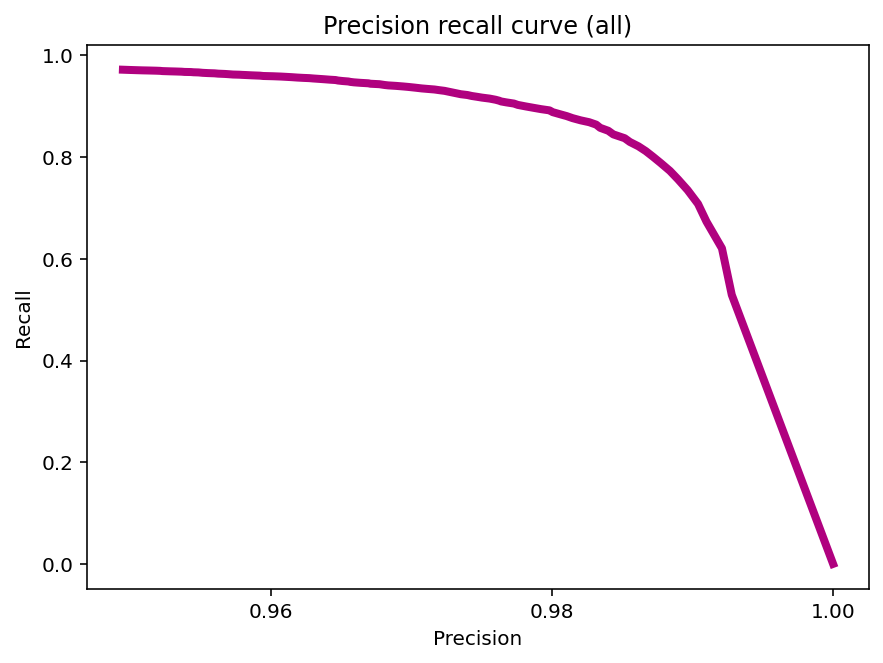

In [70]:
import matplotlib.pyplot as plt 
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

In [180]:
#quiz1
precision_threshold = pd.concat([pd.Series(precision_all) , pd.Series(threshold_values)], axis=1)
precision_threshold.columns = ['precision','threshold']
precision_threshold[precision_threshold['precision']>=0.965].head()

,precision,threshold
45,0.965099,0.727273
46,0.966343,0.732323
47,0.966492,0.737374
48,0.967167,0.742424
49,0.968027,0.747475


In [181]:
#quiz 2

new_decisions98 = pd.DataFrame(probabilities_series.apply(lambda x: 1 if x >= 0.98 else -1))
print(probabilities_series.shape)
print(test_data['sentiment'].shape)
#print(probabilities_series)
#print(test_data['sentiment'])
test_data98 = test_data['sentiment'].reset_index(drop=True)
#print(test_data98)
merge = pd.concat([new_decisions98, test_data98], axis = 1)
merge.columns = ['decision','sentiment']
print(merge.head())
pred_neg = merge[merge['decision'] == -1]
false_neg_98 = sum(pred_neg['sentiment']==1)/len(pred_neg)
print(false_neg_98)
print(sum(pred_neg['sentiment']==1))

(33336,)
(33336,)
   decision  sentiment
0        -1          1
1         1          1
2        -1          1
3         1          1
4         1          1
0.6202436456610017
8248


Quiz Question: Among all the threshold values tried, what is the smallest threshold value that achieves a precision of 96.5% or better? Round your answer to 3 decimal places.

Answer: 0.707

Quiz Question: Using threshold = 0.98, how many false negatives do we get on the test_data? This is the number of false negatives (i.e the number of reviews to look at when not needed) that we have to deal with using this classifier.

Answer: 8248

## Evaluating specific search terms

So far, we looked at the number of false positives for the entire test set. In this section, let's select reviews using a specific search term and optimize the precision on these reviews only. After all, a manufacturer would be interested in tuning the false positive rate just for their products (the reviews they want to read) rather than that of the entire set of products on Amazon.

## Precision-Recall on all baby related items

From the test set, select all the reviews for all products with the word 'baby' in them. If you are using SFrame, generate a binary mask with apply() and index test_data with the mask. Save the selection to a new data frame named baby_reviews.

In [182]:
test_data['name_str']=test_data['name'].astype(str)
baby_reviews = test_data[test_data['name_str'].apply(lambda x: 'baby' in x.lower())]
#print(baby_reviews)

/Users/kevinwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Now, let's predict the probability of classifying these reviews as positive. Make sure to convert the column review_clean of baby_reviews into a 2D array before computing class probability values. In scikit-learn, this task would be implemented as follows:

In [186]:
from sklearn.feature_extraction.text import CountVectorizer

baby_matrix = vectorizer.transform(baby_reviews['review_clean'])

probabilities_baby = model.predict_proba(baby_matrix)[:,1]
probabilities_baby_series = pd.Series(probabilities_baby)
baby_reviews2 = baby_reviews.reset_index(drop=True)
ddd = pd.concat([probabilities_baby_series, baby_reviews2], axis=1)
#print(ddd.head())
#print(ddd[[0,'name']].head())

Let's plot the precision-recall curve for the baby_reviews dataset. We again use 100 equally spaced values between 0.5 and 1 for the threshold.

In [166]:
threshold_values = np.linspace(0.5, 1, num=100)

For each of the values of threshold, we first obtain class predictions for baby_reviews using that threshold. Then we compute the precision and recall scores for baby_reviews. Save the precision scores and recall scores to lists precision_all and recall_all, respectively.

In [184]:
#quiz1
precision_all = [precision_score(y_true=baby_reviews['sentiment'], y_pred=apply_threshold(probabilities_baby, threshold))
                 for threshold in threshold_values ]

#print(precision_all)

recall_all = [recall_score(y_true=baby_reviews['sentiment'], y_pred=apply_threshold(probabilities_baby, threshold))
                 for threshold in threshold_values]

precision_threshold = pd.concat([pd.Series(precision_all) ,pd.Series(threshold_values)], axis=1)
precision_threshold.columns = ['precision','threshold']
precision_threshold[precision_threshold['precision']>=0.965].head()

,precision,threshold
45,0.965099,0.727273
46,0.966343,0.732323
47,0.966492,0.737374
48,0.967167,0.742424
49,0.968027,0.747475


Quiz Question: Among all the threshold values tried, what is the smallest threshold value that achieves a precision of 96.5% or better for the reviews of data in baby_reviews? Round your answer to 3 decimal places.

Answer: 0.727273

Quiz Question: Is this threshold value smaller or larger than the threshold used for the entire dataset to achieve the same specified precision of 96.5%?

Answer: larger (0.727 > 0.703)

Plot the precision-recall curve for baby_reviews only by running

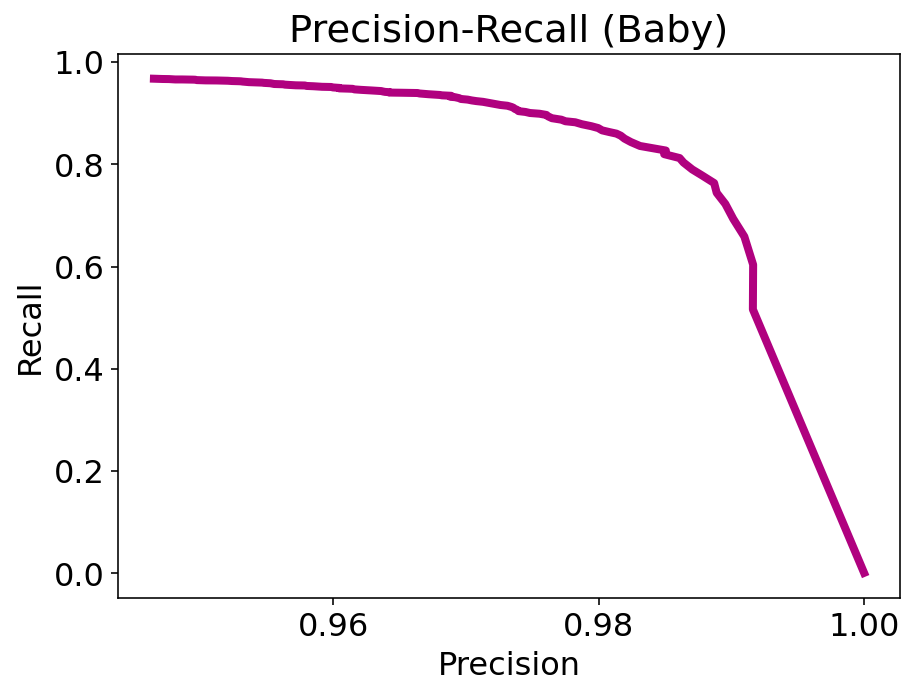

In [173]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")